<p align="right">
    <img src="Zewail-City.png">
</p>

---

# __Mini-Boson Stars: Numerical Analysis:__


In [2]:
# Main libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from matplotlib.ticker import ScalarFormatter, FuncFormatter

In [3]:
# Constants (SI units)
G = 6.67430e-11               
omega = 0.7 # Oscillation frequency (ω < 1 for bound state)
m = 1   # Scalar particle mass

### Metric and Scalar Field Ansatz

We define the spacetime and scalar field configuration as:

- Metric:
$$
ds^2 = -e^{2\Phi(r)} dt^2 + e^{2\Lambda(r)} dr^2 + r^2 d\Omega^2
$$

- Scalar Field:
$$
\phi(r,t) = \phi_0(r) \, e^{i\omega t}
$$


### System of ODEs

From the Einstein–Klein–Gordon system, we obtain:

- Mass Function:
$$
m'(r) = 4\pi G r^2 \left[ \omega^2 \phi_0^2 + e^{2(\Phi - \Lambda)} (\phi_0')^2 + m_b^2 e^{2\Phi} \phi_0^2 \right]
$$

- Gravitational Potential:
$$
\Phi'(r) = \frac{m(r) + 4\pi G r^3 \left[ (\phi_0')^2 + e^{2(\Lambda - \Phi)} \omega^2 \phi_0^2 - m_b^2 e^{2\Lambda} \phi_0^2 \right]}{r(r - 2Gm(r))}
$$

- Scalar Field Equation:
$$
\phi_0'' + \left( \frac{2}{r} + \Lambda' - \Phi' \right)\phi_0' + \left( \omega^2 e^{2(\Lambda - \Phi)} - m_b^2 e^{2\Lambda} \right)\phi_0 = 0
$$

- Metric Closure:
$$
\Lambda(r) = -\frac{1}{2} \ln\left(1 - \frac{2Gm(r)}{r} \right)
$$


In [6]:
# Define the system with p as an additional parameter
def system(r, y, p):
    omega = p  # Extract omega from the parameter list
    Phi, m, phi0, dphi0 = y

    # Avoid division by zero near origin
    eps = 1e-10
    r_adj = r + eps

    # Compute Lambda from m(r)
    Lambda = -0.5 * np.log(1 - 2 * m / r_adj)

    # Compute dLambda/dr
    dLambda_dr = (4 * np.pi * r**3 * (
        omega**2 * phi0**2 +
        np.exp(2*(Phi - Lambda)) * dphi0**2 +
        np.exp(2*Phi) * phi0**2
    ) - m) / (r * (r - 2*m + eps))

    # Einstein equations
    dm_dr = 4 * np.pi * r**2 * (
        omega**2 * phi0**2 +
        np.exp(2*(Phi - Lambda)) * dphi0**2 +
        np.exp(2*Phi) * phi0**2
    )

    dPhi_dr = (
        (m + 4 * np.pi * r**3 * (
            dphi0**2 +
            np.exp(2*(Lambda - Phi)) * omega**2 * phi0**2 -
            np.exp(2*Lambda) * phi0**2
        )) /
        (r * (r - 2*m + eps))
    )

    # Klein-Gordon equation
    ddphi0_dr = -(
        (2/r + dLambda_dr - dPhi_dr) * dphi0 +
        (omega**2 * np.exp(2*(Lambda - Phi)) - np.exp(2*Lambda)) * phi0
    )

    return [dPhi_dr, dm_dr, dphi0, ddphi0_dr]

To obtain physical solutions, we impose the following boundary conditions at the origin and at infinity:

**At** $ r = 0 $:

$$
\begin{aligned}
    \phi_0(0) &= \phi_c \\
    \Phi(0) &= 0 \\
    a(0) &= 1
\end{aligned}
$$

**As** $ r \to \infty $:

$$
\begin{aligned}
    \lim_{r \to \infty} \phi_0(r) &= 0 \\
    \lim_{r \to \infty} \alpha(r) &= \lim_{r \to \infty} \frac{1}{a(r)}
\end{aligned}
$$

These conditions ensure regularity at the center and asymptotic flatness of the spacetime.


In [8]:
def bc(ya, yb, p):
    omega = p[0]  # Extract omega from parameters
    Phi_a, m_a, phi0_a, dphi0_a = ya
    Phi_b, m_b, phi0_b, dphi0_b = yb

    return [
        phi0_a - phi_center,   # Central scalar field value
        dphi0_a,               # No cusp at center
        phi0_b,                # Scalar field vanishes at infinity
        Phi_b,                 # Gravitational potential flat at infinity
        m_a                    # No point mass at center
    ]

In [9]:
# Initial guesses
phi_center = 0.01     # Central scalar field value
Phi_center = 0.0      # Central gravitational potential
M_guess = 1.0         # Total mass guess

# Grid
r_center = 1e-6
r_inf = 30
r = np.linspace(r_center, r_inf, 1000)

# Initial guess for fields
Phi_initial = np.zeros_like(r)
m_initial = np.zeros_like(r)
phi0_initial = phi_center * np.exp(-r**2)  # Gaussian ansatz
dphi0_initial = -2 * r * phi_center * np.exp(-r**2)

# Stack into initial guess
y_initial = np.vstack([Phi_initial, m_initial, phi0_initial, dphi0_initial])

In [10]:
sol = solve_bvp(system, bc, r, y_initial, p=(omega,))

In [11]:
# Extract solution
r_sol = sol.x
Phi_sol, m_sol, phi0_sol, dphi0_sol = sol.y

# Compute Lambda(r), avoid division by zero
Lambda_sol = -0.5 * np.log(1 - 2 * m_sol / (r_sol + 1e-10))

# Compute exponential terms
exp_neg_2Phi = np.exp(-2 * Phi_sol)
exp_neg_2Lambda = np.exp(-2 * Lambda_sol)

# Derived quantities
rho_sol = (omega**2 * exp_neg_2Phi * phi0_sol**2) + (exp_neg_2Lambda * dphi0_sol**2) + (m**2 * phi0_sol**2)
P_r_sol = (exp_neg_2Lambda * dphi0_sol**2) + (omega**2 * exp_neg_2Phi * phi0_sol**2) - (m**2 * phi0_sol**2)
P_perp_sol = (-exp_neg_2Lambda * dphi0_sol**2) + (m**2 * phi0_sol**2) - (omega**2 * exp_neg_2Phi * phi0_sol**2)

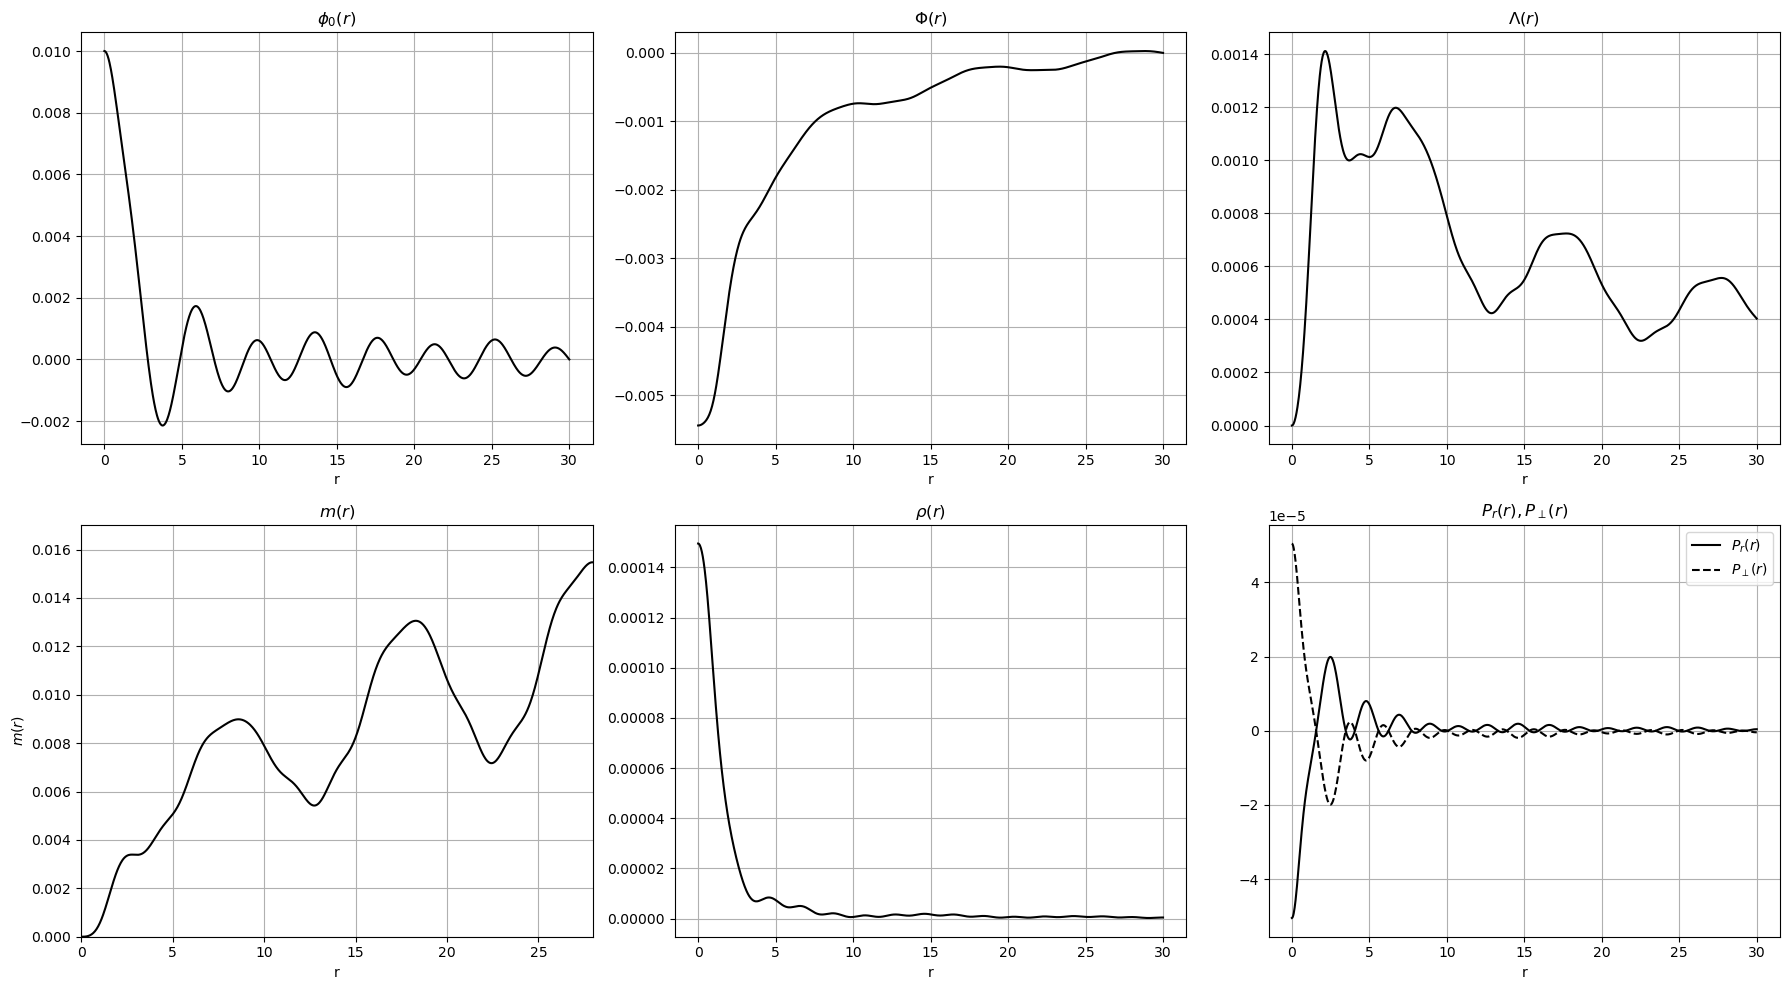

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].plot(r_sol, phi0_sol, 'k')
axs[0, 0].set_title(r'$\phi_0(r)$')

axs[0, 1].plot(r_sol, Phi_sol, 'k')
axs[0, 1].set_title(r'$\Phi(r)$')

axs[0, 2].plot(r_sol, Lambda_sol, 'k')
axs[0, 2].set_title(r'$\Lambda(r)$')

# Plot m(r)
axs[1, 0].plot(r_sol, np.clip(m_sol, 0, None), 'k')
axs[1, 0].set_title(r'$m(r)$')
max_r = r_sol[np.argmax(m_sol)]
axs[1, 0].set_xlim(0, max_r)
axs[1, 0].set_ylim(0, np.max(m_sol) * 1.1)
axs[1, 0].grid(True)
axs[1, 0].set_xlabel('r')
axs[1, 0].set_ylabel(r'$m(r)$')

axs[1, 1].plot(r_sol, rho_sol, 'k')
axs[1, 1].set_title(r'$\rho(r)$')

axs[1, 2].plot(r_sol, P_r_sol, 'k', label=r'$P_r(r)$')
axs[1, 2].plot(r_sol, P_perp_sol, 'k--', label=r'$P_\perp(r)$')
axs[1, 2].legend()
axs[1, 2].set_title(r'$P_r(r), P_\perp(r)$')

for ax in axs.flat:
    ax.set_xlabel('r')
    ax.grid(True)

plt.tight_layout()
plt.savefig("basic_profiles.png")
plt.show()

### Implicit Equation of State: $ p_r(r) $ vs. $ \rho(r) $

From the energy-momentum tensor, we extract:

$$
\rho(r) = \omega^2 e^{-2\Phi} \phi_0^2 + e^{-2\Lambda} (\phi_0')^2 + m_b^2 \phi_0^2
$$
$$
p_r(r) = e^{-2\Lambda} (\phi_0')^2 + \omega^2 e^{-2\Phi} \phi_0^2 - m_b^2 \phi_0^2
$$


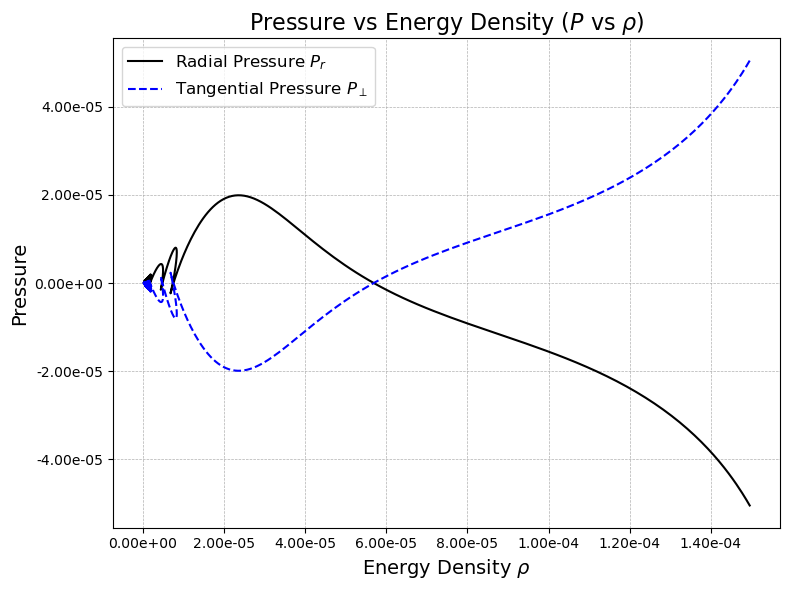

In [14]:
from matplotlib.ticker import FuncFormatter

energy_density = rho_sol
radial_pressure = P_r_sol
tangential_pressure = P_perp_sol

plt.figure(figsize=(8, 6))
plt.plot(energy_density, radial_pressure, 'k', label=r'Radial Pressure $P_r$')
plt.plot(energy_density, tangential_pressure, 'b--', label=r'Tangential Pressure $P_\perp$')

plt.xlabel(r'Energy Density $\rho$', fontsize=14)
plt.ylabel(r'Pressure', fontsize=14)
plt.title(r'Pressure vs Energy Density $(P \text{ vs } \rho)$', fontsize=16)

def sci_notation(x, pos):
    if 1e-3 < abs(x) < 1e3:
        return f'{x:.2f}'
    else:
        return f'{x:.2e}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(sci_notation))
plt.gca().yaxis.set_major_formatter(FuncFormatter(sci_notation))

plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("pressure_vs_density.png")
plt.show()

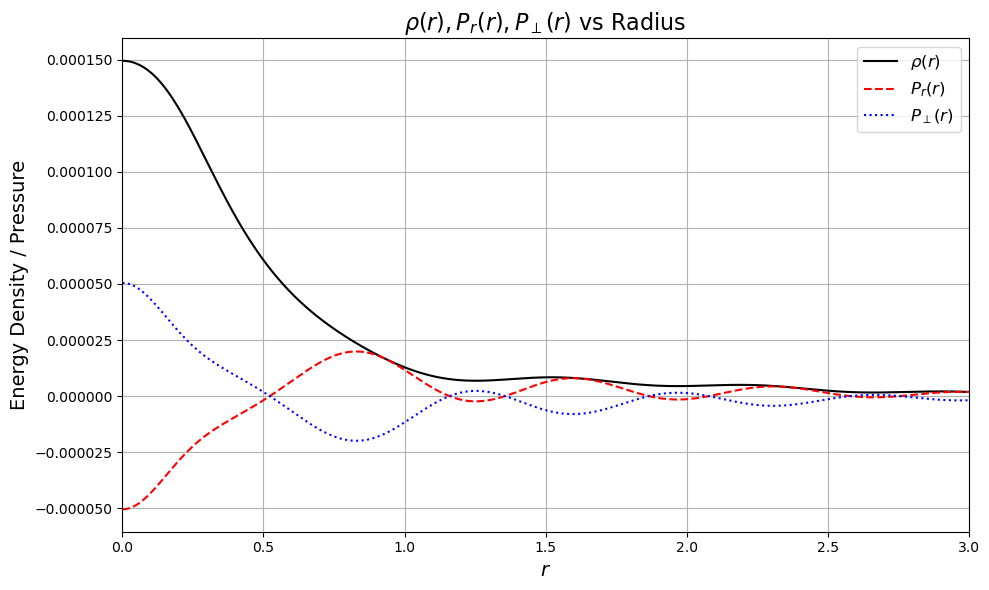

In [15]:
r_plot = np.linspace(0, 10, len(rho_sol))

plt.figure(figsize=(10, 6))
plt.plot(r_plot, rho_sol, 'k-', label=r'$\rho(r)$')
plt.plot(r_plot, P_r_sol, 'r--', label=r'$P_r(r)$')
plt.plot(r_plot, P_perp_sol, 'b:', label=r'$P_{\perp}(r)$')

plt.xlabel(r'$r$', fontsize=14)
plt.ylabel(r'Energy Density / Pressure', fontsize=14)
plt.title(r'$\rho(r), P_r(r), P_{\perp}(r)$ vs Radius', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xlim(0, 3)
plt.tight_layout()
plt.savefig("rho_pressures_vs_radius.png")
plt.show()

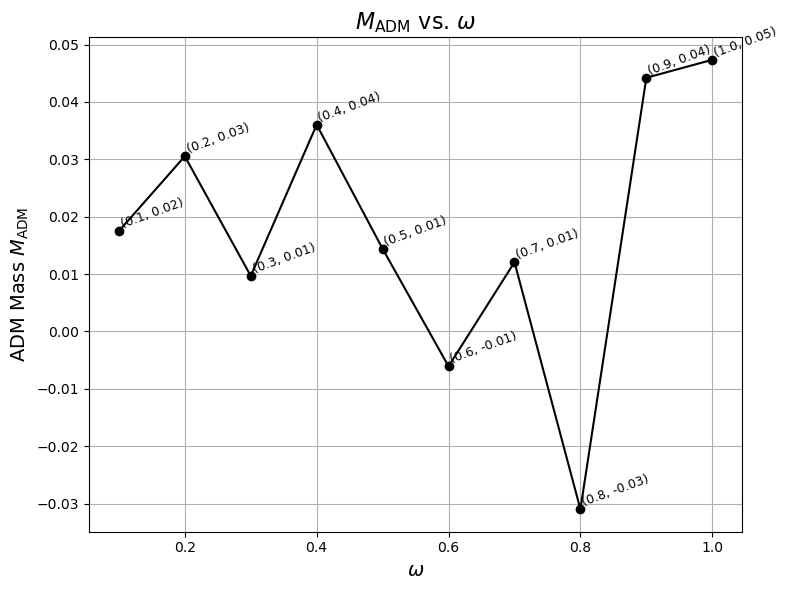

In [16]:
omegas = np.linspace(0.1, 1, 10)
masses = []

for omega in omegas:
    sol = solve_bvp(system, bc, r, y_initial, p=(omega,))
    M_ADM = sol.y[1][-1]
    masses.append(M_ADM)

plt.figure(figsize=(8, 6))
plt.plot(omegas, masses, 'k-', marker='o')
plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel(r'ADM Mass $M_{\text{ADM}}$', fontsize=14)
plt.title(r'$M_{\text{ADM}}$ vs. $\omega$', fontsize=16)
plt.grid(True)

for x, y in zip(omegas, masses):
    plt.text(x, y, f'({x:.1f}, {y:.2f})', fontsize=9,
             ha='left', va='bottom', rotation=20)

plt.tight_layout()
plt.savefig("ADM_mass_vs_omega.png")
plt.show()


## Dimensional Analysis and Unit Rescaling

In this study, we perform numerical simulations of boson star configurations in geometrized natural units, where the fundamental constants $ G = c = \hbar = m_b = 1 $ are set to unity. This unit system renders all physical quantities dimensionless. To interpret the simulation results in conventional physical units (e.g., kilometers, solar masses, Hertz, joules per cubic meter), we apply appropriate scaling relations derived from dimensional analysis and the properties of the Einstein–Klein–Gordon system.

### Length Scale: Compton Wavelength

The characteristic length scale is set by the reduced Compton wavelength of the boson:
$$
\lambda_c = \frac{\hbar}{m_b c},
$$
which represents the quantum wavelength associated with a scalar particle of mass $ m_b $. Dimensionless radial coordinates $ r_{\text{sol}} $ are converted to physical length via:
$$
r_{\text{phys}} = r_{\text{sol}} \cdot \lambda_c.
$$

### Mass Scale

The natural mass scale is derived from combining the gravitational constant and the boson mass:
$$
M_0 = \frac{\hbar}{G m_b}.
$$
To express results in solar mass units, the dimensionless mass $ m_{\text{sol}} $ is scaled as:
$$
m_{\text{phys}} = m_{\text{sol}} \cdot \left( \frac{M_0}{M_\odot} \right),
$$
where $ M_\odot \approx 1.9885 \times 10^{30}~\text{kg} $ denotes the solar mass.

### Frequency Scale

The frequency scale is established by the boson rest energy:
$$
f_{\text{scale}} = \frac{m_b c^2}{\hbar}.
$$
Thus, dimensionless frequencies $ \omega $ are converted to Hertz using:
$$
\omega_{\text{phys}} = \omega \cdot f_{\text{scale}}.
$$

### Energy Density and Pressure Scale

The energy density and pressure scale is determined from the stress-energy tensor associated with the scalar field. The relevant scale is given by:
$$
\rho_0 = \frac{m_b^4 c^6}{\hbar^3}.
$$
All simulated quantities such as energy density $ \rho_{\text{sol}} $, radial pressure $ P_{r,\text{sol}} $, and tangential pressure $ P_{\perp,\text{sol}} $ are rescaled as follows:
$$
\rho_{\text{phys}} = \rho_{\text{sol}} \cdot \rho_0, \quad
P_{r,\text{phys}} = P_{r,\text{sol}} \cdot \rho_0, \quad
P_{\perp,\text{phys}} = P_{\perp,\text{sol}} \cdot \rho_0.
$$

### Scalar Field Amplitude

The amplitude of the scalar field $ \phi_0 $ enters the energy-momentum tensor quadratically, and thus must be rescaled to yield consistent energy densities in SI units. Dimensional analysis indicates that the physical units of $ \phi_0 $ are:
$$
[\phi_0] = \left( \frac{\text{J} \cdot \text{s}}{\text{m}^3} \right)^{1/2} = \left( \frac{\text{kg}}{\text{m}} \right)^{1/2}.
$$
Accordingly, we rescale the dimensionless field amplitude using:
$$
\phi_{0,\text{phys}} = \frac{\phi_{0,\text{sol}}}{\sqrt{ \rho_0 }}.
$$

### Summary of Scaling Relations

$$
\begin{array}{|c|c|c|c|}
\hline
\textbf{Quantity} & \textbf{Scaling Formula} & \textbf{Description} & \textbf{Units} \\
\hline
\text{Length} & \lambda_c = \frac{\hbar}{m_b c} & \text{Radial coordinate scaling} & \text{m} \\
\hline
\text{Mass} & M_0 = \frac{\hbar}{G m_b} & \text{Mass of star in } M_\odot & \text{kg or } M_\odot \\
\hline
\text{Frequency} & f = \frac{m_b c^2}{\hbar} & \text{Boson frequency} & \text{Hz} \\
\hline
\text{Energy Density} & \rho_0 = \frac{m_b^4 c^6}{\hbar^3} & \text{Scalar field energy density} & \text{J/m}^3 \\
\hline
\end{array}
$$

These scaling relations ensure that all computed quantities are consistent with their respective SI units and facilitate the interpretation of simulation outputs in astrophysical contexts. Moreover, the rescalings are not arbitrary; they are dictated by the intrinsic dimensional structure of the field equations and the properties of the scalar field Lagrangian.


In [18]:
def convert_to_physical_units(r_sol, m_sol, phi0_sol, omega, rho_sol, P_r_sol, P_perp_sol, m_b_eV):
    """
    Converts simulation results from dimensionless (geometrized) units to physical units.
    
    Parameters:
    - r_sol: Radial coordinate (dimensionless)
    - m_sol: Mass profile (dimensionless)
    - phi0_sol: Scalar field amplitude (dimensionless)
    - omega: Frequency (dimensionless)
    - rho_sol: Energy density (dimensionless)
    - P_r_sol: Radial pressure (dimensionless)
    - P_perp_sol: Tangential pressure (dimensionless)
    - m_b_eV: Boson mass in eV/c^2
    
    Returns:
    - Dictionary with all converted quantities in physical units
    """
    
    # Constants in SI units
    hbar = 6.582176634e-25  # GeV·s
    c = 2.99792458e10        # cm/s
    G = 6.67430e-11          # m^3 kg^-1 s^-2
    M_sun = 1.98847e30       # kg
    eV_to_J = 1.60218e-19    # J
    
    # Convert m_b from eV to GeV for unit consistency
    m_b_GeV = m_b_eV * 1e-9
    
    # Compute scales
    lambda_c_m = (hbar / (m_b_GeV * c)) * 1e2  # meters
    M_scale_kg = hbar / (G * m_b_GeV)
    M_scale_Msun = M_scale_kg / M_sun
    rho_scale = ((m_b_GeV**4 * c**6) / hbar**3) * eV_to_J * 1e6  # J/m^3
    freq_scale = (m_b_GeV * c**2) / hbar  # Hz

    # Convert each quantity
    r_phys = r_sol * lambda_c_m / 1e3  # km
    m_phys = m_sol * M_scale_Msun
    phi0_phys = phi0_sol / np.sqrt(1e-9 / (m_b_GeV * eV_to_J))  # Rough scaling
    omega_phys = omega * freq_scale
    rho_phys = rho_sol * rho_scale
    P_r_phys = P_r_sol * rho_scale
    P_perp_phys = P_perp_sol * rho_scale

    return {
        'r_km': r_phys,
        'm_Msun': m_phys,
        'phi0': phi0_phys,
        'omega_hz': omega_phys,
        'rho_J_per_m3': rho_phys,
        'P_r_J_per_m3': P_r_phys,
        'P_perp_J_per_m3': P_perp_phys,
        'lambda_c_m': lambda_c_m,
        'M_scale_Msun': M_scale_Msun,
        'rho_scale': rho_scale,
        'freq_scale': freq_scale
    }

In [19]:
def convert_to_physical_units_df(r_sol, m_sol, phi0_sol, omega, rho_sol, P_r_sol, P_perp_sol, m_b_eV):
    """
    Converts simulation results from dimensionless (geometrized) units to physical units,
    and returns a pandas DataFrame.

    Parameters:
    - r_sol, m_sol, phi0_sol, omega, rho_sol, P_r_sol, P_perp_sol: Arrays or scalars of dimensionless quantities
    - m_b_eV: Scalar, boson mass in eV/c^2

    Returns:
    - df: pandas DataFrame with physical quantities
    """
    
    # Constants in SI units
    hbar = 6.582176634e-25  # GeV·s
    c = 2.99792458e10       # cm/s
    G = 6.67430e-11         # m^3 kg^-1 s^-2
    M_sun = 1.98847e30      # kg
    eV_to_J = 1.60218e-19   # J

    # Convert m_b from eV to GeV for unit consistency
    m_b_GeV = m_b_eV * 1e-9

    # Compute scales
    lambda_c_m = (hbar / (m_b_GeV * c)) * 1e2              # meters
    M_scale_kg = hbar / (G * m_b_GeV)
    M_scale_Msun = M_scale_kg / M_sun
    rho_scale = ((m_b_GeV**4 * c**6) / hbar**3) * eV_to_J * 1e6  # J/m^3
    freq_scale = (m_b_GeV * c**2) / hbar                     # Hz

    # Convert quantities
    r_phys = np.array(r_sol) * lambda_c_m / 1e3             # km
    m_phys = np.array(m_sol) * M_scale_Msun
    omega_phys = omega * freq_scale
    rho_phys = np.array(rho_sol) * rho_scale
    P_r_phys = np.array(P_r_sol) * rho_scale
    P_perp_phys = np.array(P_perp_sol) * rho_scale

    # If phi0_sol is a scalar, convert directly; else vectorize
    if np.isscalar(phi0_sol):
        phi0_phys = phi0_sol / np.sqrt(1e-9 / (m_b_GeV * eV_to_J))
        phi0_phys = np.full_like(r_phys, phi0_phys)
    else:
        phi0_phys = np.array(phi0_sol) / np.sqrt(1e-9 / (m_b_GeV * eV_to_J))

    # Create DataFrame
    df = pd.DataFrame({
        'r_km': r_phys,
        'm_Msun': m_phys,
        'phi0': phi0_phys,
        'omega_Hz': np.full_like(r_phys, omega_phys),
        'rho_J_m3': rho_phys,
        'P_r_J_m3': P_r_phys,
        'P_perp_J_m3': P_perp_phys
    })
    return df

In [20]:
# Sample data from your code
r_sol = np.linspace(0, 30, 1000)
m_sol = np.random.rand(1000) * 0.1 
phi0_sol = np.exp(-r_sol**2)
omega = 0.9
rho_sol = phi0_sol**2
P_r_sol = phi0_sol**2
P_perp_sol = phi0_sol**2

# Choose a boson mass (e.g., Higgs Boson)
m_b_eV = 125 * 1e9  # eV

# Convert to physical units
converted = convert_to_physical_units(r_sol, m_sol, phi0_sol, omega, rho_sol, P_r_sol, P_perp_sol, m_b_eV)

# Print some values
print("Physical radius at max mass:", converted['r_km'][np.argmax(converted['m_Msun'])])
print("Maximum mass:", np.max(converted['m_Msun']), "M☉")
print("Compton wavelength:", converted['lambda_c_m'], "meters")

Physical radius at max mass: 2.5951333917849294e-37
Maximum mass: 3.967042828533388e-48 M☉
Compton wavelength: 1.7564622346837021e-35 meters


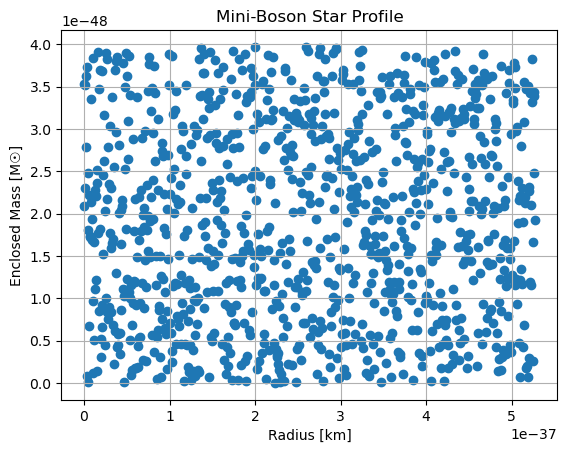

In [21]:
plt.scatter(converted['r_km'], converted['m_Msun'])
plt.xlabel("Radius [km]")
plt.ylabel("Enclosed Mass [M☉]")
plt.title("Mini-Boson Star Profile")
plt.grid(True)
plt.show()

In [22]:
# Convert dataframe
df = convert_to_physical_units_df(r_sol, m_sol, phi0_sol, omega, rho_sol, P_r_sol, P_perp_sol, m_b_eV)
df.head()

,r_km,m_Msun,phi0,omega_Hz,rho_J_m3,P_r_J_m3,P_perp_J_m3
0,0.000000e+00,3.534328e-48,0.000142,1.536117e+47,9.957882e+130,9.957882e+130,9.957882e+130
1,5.274661e-40,2.084492e-48,0.000141,1.536117e+47,9.939938e+130,9.939938e+130,9.939938e+130
2,1.054932e-39,3.513397e-48,0.000141,1.536117e+47,9.886300e+130,9.886300e+130,9.886300e+130
3,1.582398e-39,2.303240e-48,0.000140,1.536117e+47,9.797546e+130,9.797546e+130,9.797546e+130
4,2.109865e-39,2.789802e-48,0.000139,1.536117e+47,9.674627e+130,9.674627e+130,9.674627e+130


---